In [1]:
import torch
import yaml
import glob
import numpy as np
import matplotlib.pyplot as plt

from wpsml.vit2d import ViT2D
from wpsml.data import ERA5Dataset, ToTensor, NormalizeState, NormalizeTendency
from torchvision import transforms
import gc

In [45]:
save_loc = '../results/casper/1214/vit2d/' #conf['save_loc']
device = "cuda"

config_file = f"{save_loc}/model.yml"

In [46]:
with open(config_file) as cf:
        conf = yaml.load(cf, Loader=yaml.FullLoader)

In [47]:
history_len = 10
forecast_len = 11
time_step = 1
    
# datasets (zarr reader) 
all_ERA_files = sorted(glob.glob(conf["data"]["save_loc"]))
    
# Specify the years for each set
test_years = [str(year) for year in range(2018, 2022)] # same as graphcast -- always hold out

# Filter the files for each set
test_files = [file for file in all_ERA_files if any(year in file for year in test_years)]

test_dataset = ERA5Dataset(
    filenames=test_files,
    history_len=history_len, 
    forecast_len=forecast_len, 
    skip_periods=time_step,
    transform=transforms.Compose([
        NormalizeState(conf["data"]["mean_path"],conf["data"]["std_path"]),
        ToTensor(history_len=history_len, forecast_len=forecast_len),
    ]),
)

# setup the dataloder for this process
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    pin_memory=True, 
    num_workers=0,
    drop_last=True)

In [48]:
def cycle(dl):
    while True:
        for data in dl:
            yield data
            
# cycle for later so we can accum grad dataloader
dl = cycle(test_loader)

In [49]:
model = ViT2D(
        image_height=conf['model']['image_height'],
        patch_height=conf['model']['patch_height'],
        image_width=conf['model']['image_width'],
        patch_width=conf['model']['patch_width'],
        frames=conf['model']['frames'],
        frame_patch_size=conf['model']['frame_patch_size'],
        dim=conf['model']['dim'],
        channels=conf['model']['channels'],
        surface_channels=conf['model']['surface_channels'],
        depth=conf['model']['depth'],
        heads=conf['model']['heads'],
        dim_head=conf['model']['dim_head'],
        mlp_dim=conf['model']['mlp_dim'],
        num_register_tokens=conf['model']['num_register_tokens'],
        use_registers=conf['model']['use_registers'],
        token_dropout=conf['model']['token_dropout'],
        use_codebook=conf['model']['use_codebook'],
        vq_codebook_size=conf['model']['vq_codebook_size'],
        vq_decay=conf['model']['vq_decay'],
        vq_commitment_weight=conf['model']['vq_commitment_weight'],
).to(device)

In [50]:
checkpoint = torch.load(f"{save_loc}/checkpoint.pt", map_location=device)

In [51]:
model.load_state_dict(checkpoint["model_state_dict"]) 

<All keys matched successfully>

In [52]:
batch = next(dl)

0 tensor(0.1997, device='cuda:0')


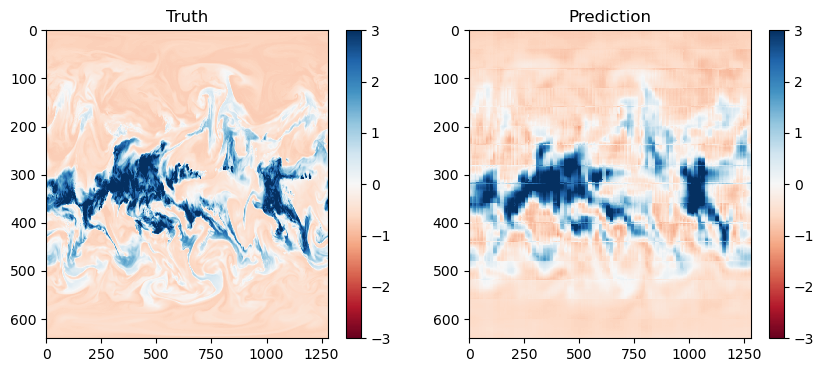

1 tensor(0.2166, device='cuda:0')


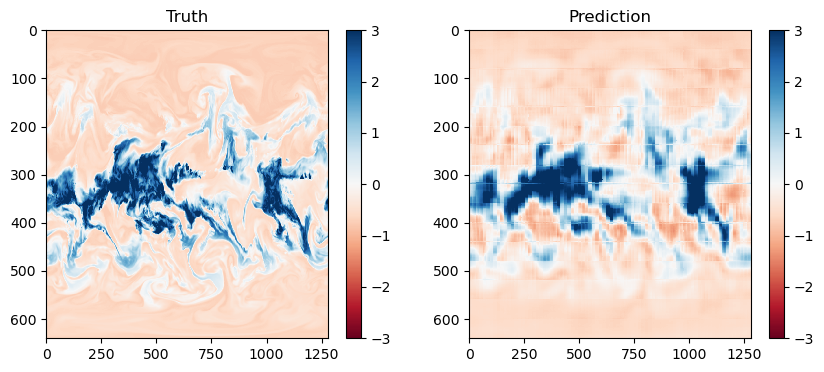

2 tensor(0.2367, device='cuda:0')


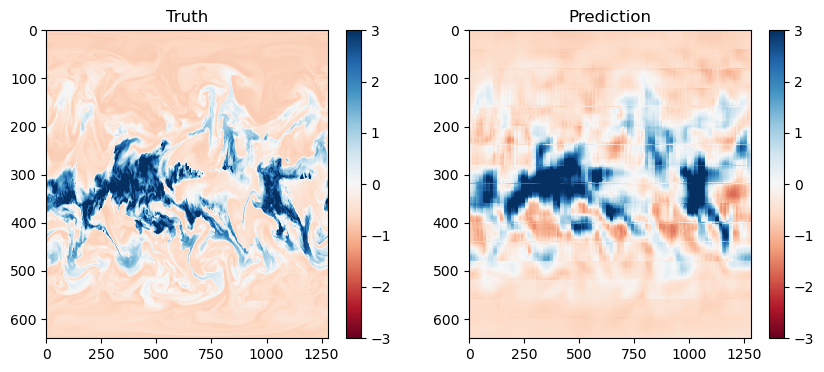

3 tensor(0.2581, device='cuda:0')


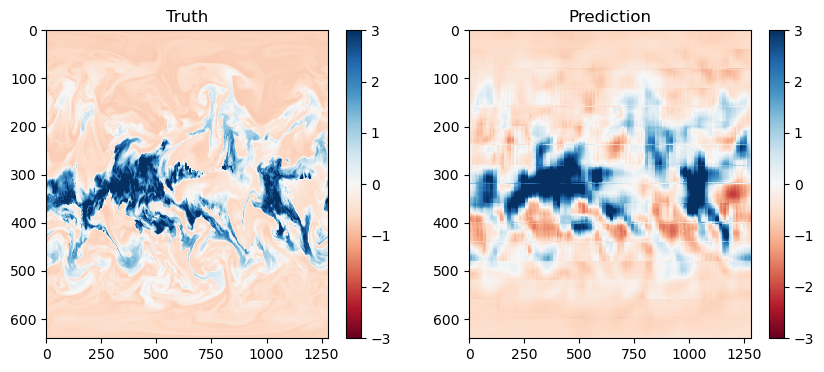

4 tensor(0.2797, device='cuda:0')


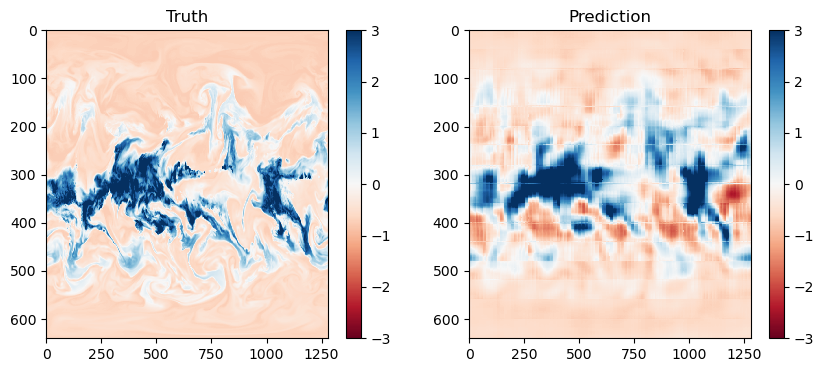

5 tensor(0.3012, device='cuda:0')


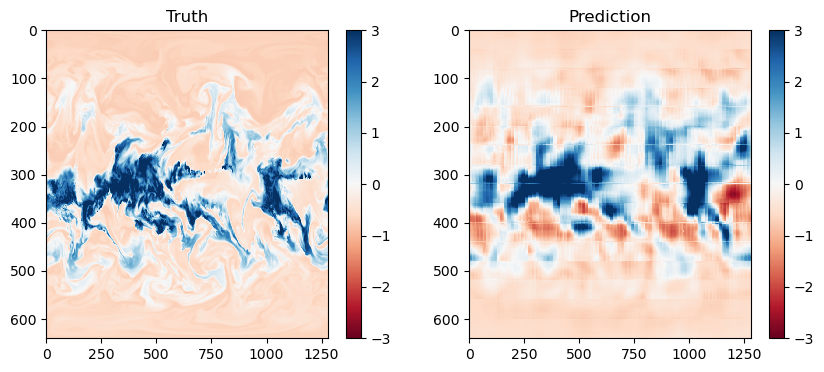

6 tensor(0.3223, device='cuda:0')


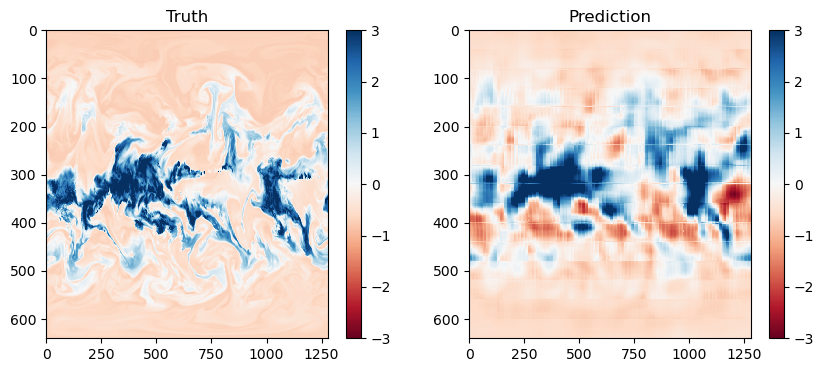

7 tensor(0.3424, device='cuda:0')


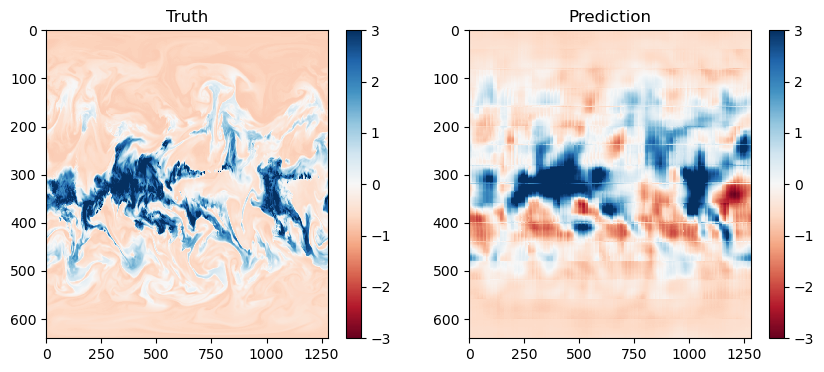

8 tensor(0.3613, device='cuda:0')


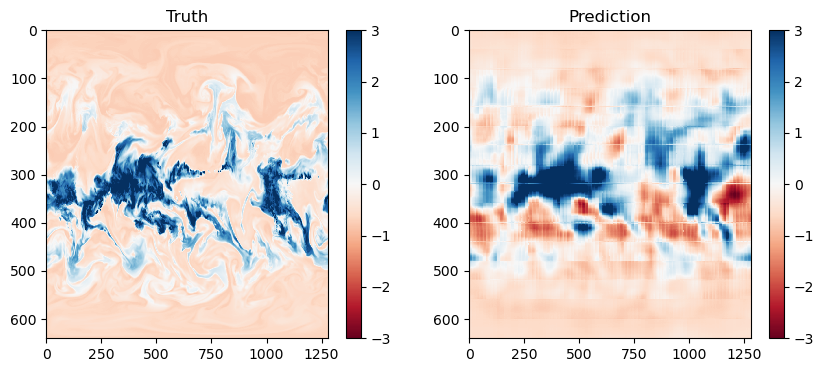

In [53]:
with torch.no_grad(): 
    
    loss_fn = torch.nn.L1Loss()
    
    # Initialize x and x_surf with the first time step
    x_atmo = batch["x"][:, 0]
    x_surf = batch["x_surf"][:, :, 0]
    x = model.concat_and_reshape(x_atmo, x_surf).to(device)

    loss = 0.0
    for i in range(batch["x"].shape[1]-1):

        y_atmo = batch["y"][:, i]
        y_surf = batch["y_surf"][:, :, i]
        y = model.concat_and_reshape(y_atmo, y_surf).to(device)

        # The model's output y_pred becomes the new x for the next time step
        y_pred = model(x)
        x = y_pred.detach()

        mae = loss_fn(y, y_pred)
        print(i, mae)
        loss += mae
        
        # Plotting y
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.pcolor(y[0, 66, :, :].to('cpu').numpy(), cmap='RdBu', vmin=-3, vmax=3)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title('Truth')

        # Plotting y_pred
        plt.subplot(1, 2, 2)
        plt.pcolor(y_pred[0, 66, :, :].to('cpu').numpy(), cmap='RdBu', vmin=-3, vmax=3)
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.title('Prediction')

        plt.show()

        del y_pred, y
        # Explicitly release GPU memory
        torch.cuda.empty_cache()
        gc.collect()

In [54]:
(batch["y"][:, 9] - batch["y"][:, 0]).mean()

tensor(0.0033)